In [410]:
import einops
import torch
import torch.nn as nn

In [418]:
x=torch.rand(1, 768,8,8)
cat_avgpool_npatches = [(2,2)] #[(1,1),(2,2),(3,3)]

In [419]:
x[:,:,:h//2,:w//2] = 0
x[:,:,h//2:,:w//2] = 1
x[:,:,:h//2,w//2:] = 2
x[:,:,h//2:,w//2:] = 3

In [420]:
norms = nn.ParameterDict({f"nw{nw}_nh{nh}": nn.LayerNorm(c)
                           for nw, nh in cat_avgpool_npatches
                           })

In [421]:
b, c, h, w = x.shape

xx = einops.rearrange(x, "b c h w -> b h w c", h=h, w=w)

xs = []
xxs = []
for w1, h1 in cat_avgpool_npatches:
    #xx = norms[f"nw{w1}_nh{h1}"](xx)
    
    # add columns / rows to be patchified as desired
    add_h = h1-(h%h1) if h%h1 > 0 else 0
    add_w = w1-(w%w1) if w%w1 > 0 else 0
    if add_h > 0 or add_w > 0:
        print("IN")
        try:
            empty = torch.empty(b,h+add_h,w+add_w,c, 
                               device=x.device,
                               dtype=x.dtype,
                               )
        except:
            pass
        
        to_split = empty   
        to_split[...] = torch.nan
        to_split[:,:h,:w,:] = xx
    else:
        to_split = xx
        
    # splits the image into desired number of patches. 
    x_splitted = einops.reduce(to_split, 
                              "b (h1 h) (w1 w) c -> b (h1 w1 c)", 
                               reduction=torch.nanmean,
                               h1=h1, w1=w1)
    
    print(einops.reduce(x_splitted,
                "b (h1 w1 c) -> b h1 w1", h1=h1, w1=w1,
             reduction="mean"))
    print()
    
    xs += [x_splitted]
    # xxs += [einops.rearrange(x_splitted, 
    #                         "b (c h1 w1) -> b (h1 w1) c")]
    
    #print(x_splitted.shape)
    
out = torch.cat(xs, dim=-1)
out.shape


tensor([[[0., 2.],
         [1., 3.]]])



torch.Size([1, 3072])

In [423]:
x_splitted.shape

torch.Size([1, 3072])

In [424]:
xxx=einops.rearrange(x_splitted, 
              "b (h1 w1 c) -> b h1 w1 c", 
               h1=h1, w1=w1)

In [428]:
xxx[0,1,1,:].unique()

tensor([3.])

In [440]:
i=3
x_splitted[0,768*i:768*(i+1)].unique()

tensor([3.])

In [258]:
einops.rearrange(xs,
                "b (c h1 w1) -> b h1 w1", h1=h1, w1=w1)

(tensor([[0.6998, 0.8187, 0.2460, 0.8645],
         [0.9085, 0.9319, 0.9502, 0.2328]]),
 tensor([[0.9736, 0.1607, 0.7509, 0.3523],
         [0.7845, 0.4870, 0.4843, 0.6039]]),
 tensor([[0.8934, 0.2586, 0.8526, 0.3633],
         [0.8185, 0.3893, 0.8587, 0.1655]]))

In [257]:
torch.unbind??

Docstring:
unbind(input, dim=0) -> seq

Removes a tensor dimension.

Returns a tuple of all slices along a given dimension, already without it.

Arguments:
    input (Tensor): the tensor to unbind
    dim (int): dimension to remove

Example::

    >>> torch.unbind(torch.tensor([[1, 2, 3],
    >>>                            [4, 5, 6],
    >>>                            [7, 8, 9]]))
    (tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
Type:      builtin_function_or_method


In [242]:
cat_avgpool_npatches

[(1, 1), (2, 2), (3, 3)]

In [237]:
x_splitted[:,:].mean()

tensor(0.4962)

In [179]:
x_splitted[:,:x_splitted.shape[-1]//2].mean()

tensor(1.6667)

In [183]:
einops.reduce(x_splitted[:,:x_splitted.shape[-1]//2],
                "b (c h1 w1) -> b h1 w1", h1=h1, w1=w1,
             reduction="mean")

tensor([[[0.0000, 1.3333, 2.0000],
         [0.6667, 2.0000, 2.6667],
         [1.0000, 2.3333, 3.0000]]])

In [184]:
einops.reduce(x_splitted,
                "b (c h1 w1) -> b h1 w1", h1=h1, w1=w1,
             reduction="mean")

tensor([[[0.0000, 1.3333, 2.0000],
         [0.6667, 2.0000, 2.6667],
         [1.0000, 2.3333, 3.0000]]])

In [136]:
2048*6

12288

In [200]:
class Matryoshka(torch.nn.Linear):
    def __init__(
        self,
        matryoshka_features,
        in_features: int,
        out_features: int,
        use_bias: bool = True,
    ):
        super().__init__(in_features=in_features, out_features=out_features, bias=use_bias)
        self.matryoshka_features = matryoshka_features

    def forward(self, batch: torch.Tensor):
        
        out = [F.linear(batch[...,:d], self.weight[:,:d], self.bias)
               for d in self.matryoshka_features]
        return torch.cat(out, dim=-1)

In [206]:
model = Matryoshka(matryoshka_features=[16,32,64], 
           in_features=64, out_features=100)
model = torch.nn.Linear(61,2)

In [390]:
l=[10,30,100]
diff = np.diff(l,prepend=0)
factor=np.array([(len(l)-i)/len(l) for i in range(len(l))])
1/np.average(factor, weights=diff)

In [396]:
torch.ones(2).ndim

1

In [393]:
np.average??

Signature:
np.average(
    a,
    axis=None,
    weights=None,
    returned=False,
    *,
    keepdims=<no value>,
)
Source:   
@array_function_dispatch(_average_dispatcher)
def average(a, axis=None, weights=None, returned=False, *,
            keepdims=np._NoValue):
    """
    Compute the weighted average along the specified axis.

    Parameters
    ----------
    a : array_like
        Array containing data to be averaged. If `a` is not an array, a
        conversion is attempted.
    axis : None or int or tuple of ints, optional
        Axis or axes along which to average `a`.  The default,
        axis=None, will average over all of the elements of the input array.
        If axis is negative it counts from the last to the first axis.

        .. versionadded:: 1.7.0

        If axis is a tuple of ints, averaging is performed on all of the axes
        specified in the tuple instead of a single axis or all the axes as
        before.
    weights : array_like, optional
        An 

In [352]:
np.diff(l)

array([20, 70])

In [349]:
nn.Linear??

Init signature:
nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Att

In [207]:
model(torch.rand(10,64,1,1)).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (640x1 and 61x2)

In [116]:
add_h

1

In [338]:
from functools import partial
class BottleneckExpand(nn.Module):

    def __init__(
            self,
            in_channels,
            hidden_channels,
            expansion=8,
            NormLayer=nn.BatchNorm2d,
            Activation=partial(nn.ReLU, inplace=True),
            is_residual=True,
            layer_scale_init_value=1e-6,
            bias=False
    ):
        super().__init__()
        self.expansion = expansion
        self.is_residual = is_residual
        out_channels = in_channels * self.expansion
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=bias)
        self.norm1 = NormLayer(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, bias=bias, padding=1)
        self.norm2 = NormLayer(hidden_channels)
        self.conv3 = nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=bias)
        self.norm3 = NormLayer(out_channels)
        self.act = Activation()

        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((out_channels)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )



    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.norm1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.norm3(out)
        out = self.act(out)

        if self.is_residual:
            identity = einops.repeat(identity, 'b c h w -> b (tile c) h w', tile=self.expansion)
            out = identity + self.gamma * out

        return out


In [339]:
def convnext_small(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    return model, 768

In [340]:
model = convnext_small()[0]

NameError: name 'Z_dim_old_tmp_new' is not defined

In [345]:
768//2

384

In [346]:
model = BottleneckExpand(768,hidden_channels=384,expansion=14)

In [347]:
sum(len(p.flatten()) for p in model.parameters())

5784576

In [331]:
torch.ones((3))

tensor([1., 1., 1.])

In [324]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
import math
import einops

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath


class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, dim, tmp_dim=None, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        if tmp_dim is None:
            tmp_dim = dim
                       
        self.dwconv = nn.Conv2d(
            dim, tmp_dim, kernel_size=7, padding=3, groups=tmp_dim
        )  # depthwise conv
        self.norm = LayerNorm(tmp_dim, eps=1e-6)
        self.pwconv1 = nn.Linear(
            tmp_dim, 4 * tmp_dim
        )  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * tmp_dim, dim)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x



class DimExpander(nn.Module):
    def __init__(self, in_dim, out_dim, tmp_dim=None, **kwargs):
        super().__init__()
        if tmp_dim is None:
            tmp_dim = out_dim
            
        self.norm = LayerNorm(in_dim, eps=1e-6, data_format="channels_first")
        self.conv = nn.Conv2d(in_dim, tmp_dim, kernel_size=2, stride=2)
        self.block = Block(out_dim, tmp_dim=tmp_dim)
        
        if tmp_dim != out_dim:
            self.linear = nn.Linear(tmp_dim, out_dim)
        else:
            self.linear = nn.Identity()
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        x = self.block(x)

        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.linear(x)
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        return x
        
        
        
        

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """

    def __init__(
            self,
            in_chans=3,
            num_classes=1000,
            depths=[3, 3, 9, 3],
            dims=[96, 192, 384, 768],
            drop_path_rate=0.0,
            layer_scale_init_value=0.0,
            head_init_scale=1.0,
            is_set=True,
            is_set_normalize=False,
            patch_size=16
    ):
        super().__init__()

        signal_chans = in_chans

        if is_set_normalize:
            in_chans = signal_chans * 2
            self.set_conv = SetConv2D(signal_chans, signal_chans)
        elif is_set:
            in_chans = signal_chans + 1

        
        
        self.embed_dim = dims[-1]
        self.is_set = is_set
        self.is_set_normalize = is_set_normalize
        self.patch_size = patch_size
        self.register_buffer("base_patch",  torch.ones(1, 1, patch_size, patch_size).float())

        self.downsample_layers = (
            nn.ModuleList()
        )  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = (
            nn.ModuleList()
        )  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                    for j in range(depths[i])
                ]
            )
            self.stages.append(stage)
            cur += depths[i]
            
        if Z_dim_old_tmp_new is not None:
            old_nchan, tmp_nchan, expand_dim = Z_dim_old_tmp_new
            self.expander = DimExpander(old_nchan, expand_dim, tmp_dim=tmp_nchan)
        else:
            self.expander = nn.Identity()
            expand_dim = dims[-1]

        self.norm = nn.LayerNorm(expand_dim, eps=1e-6)  # final norm layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x 
        return x

    def forward(self, x, patch_drop=0.0):
        x = self.mask_imgs(x, patch_drop)
        x = self.forward_features(x)
        return x

    def mask_imgs(self, x, p):

        if p > 0 and not math.isclose(p, 0, abs_tol=1e-5):
            b, _, h, w = x.shape
            assert h % self.patch_size == 0 and w % self.patch_size == 0
            n_h_patch = h // self.patch_size
            n_w_patch = w // self.patch_size
            n_patches = n_h_patch * n_w_patch
            masked_patches = (torch.rand((b, n_patches, 1, 1)) > p).float().to(self.base_patch.device) * self.base_patch
            mask = einops.rearrange(masked_patches, "b (nh nw) p1 p2 -> b (nh p1) (nw p2)",
                                    nh=n_h_patch, nw=n_w_patch).unsqueeze(1)
        else:
            mask = torch.ones_like(x[:, 0:1, ...])

        if self.is_set_normalize:
            x = self.set_conv(x, mask)
        elif self.is_set:
            alpha_channel = torch.ones_like(x[:, 0:1, ...])
            x = torch.cat([x, alpha_channel], dim=1)
            x *= mask
        else:
            # does not append the mask => not a set encoder
            x *= mask

        return x


class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


def convnext_tiny(**kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    return model, 768

def convnext_small(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    return model, 768

def convnext_small_raw(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], is_set=False, **kwargs)
    return model, 768

def convnext_small_normmask(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], is_set_normalize=True, **kwargs)
    return model, 768

def convnext_base(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    return model, 1024


def convnext_large(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    return model, 1536


def convnext_xlarge(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    return model, 2048


In [67]:
h%1

0

In [35]:
xx.mean(1).mean(0).mean(-1).shape

torch.Size([2, 2])

In [36]:
xx.mean(1).mean(0).mean(-1)

tensor([[0., 2.],
        [1., 3.]])

In [1]:
import numpy as np

In [15]:
with np.load("results/exp_statistics/data_imagenet/ssl_beit_vitB16_pt22k/trainrealaug_statistics.npz") as statistics:
    print(statistics["nc1"])

FileNotFoundError: [Errno 2] No such file or directory: 'results/exp_statistics/data_imagenet/ssl_beit_vitB16_pt22k/trainrealaug_statistics.npz'

In [10]:
list(out.keys())

['nc1', 'intra_var', 'inter_var', 'alignment']

array(363.07149534)

In [12]:
ls results/exp_statistics/data_imagenet/

ssl_barlow_rn50/
ssl_barlow_rn50_ep300/
ssl_beit_vitB16_pt22k/
ssl_beit_vitL16_pt22k/
ssl_beitv2_vitB16_pt1k/
ssl_beitv2_vitB16_pt1k_ep300/
ssl_beitv2_vitB16_pt1k_extractB/
ssl_beitv2_vitL16_pt1k/
ssl_byol_rn50_augCrop/
ssl_byol_rn50_augCropBlur/
ssl_byol_rn50_augCropColor/
ssl_byol_rn50_augNocolor/
ssl_byol_rn50_augNogray/
ssl_byol_rn50_bs1024/
ssl_byol_rn50_bs128/
ssl_byol_rn50_bs2048/
ssl_byol_rn50_bs256/
ssl_byol_rn50_bs4096/
ssl_byol_rn50_bs512/
ssl_byol_rn50_bs64/
ssl_clip_rn101/
ssl_clip_rn50/
ssl_clip_rn50x16/
ssl_clip_rn50x4/
ssl_clip_rn50x64/
ssl_clip_vitB16/
ssl_clip_vitB32/
ssl_clip_vitL14/
ssl_clip_vitl14_px336/
ssl_clusterfit_rn50/
ssl_dc2_rn50_ep400_2x160_4x96/
ssl_dc2_rn50_ep400_2x224/
ssl_dc2_rn50_ep800_2x224_6x96/
ssl_deepcluster_rn50_bs512_ep200_mmselfsup/
ssl_densecl_rn50_200ep_mmselfsup/
ssl_dino_rn50/
ssl_dino_vitB16/
ssl_dino_vitB16_extractS/
ssl_dino_vitB16_last/
ssl_dino_vitB8/
ssl_dino_vitB8_last/
ssl_dino_vitS16/
ssl_dino_vitS16_extractB/
ssl_dino_vitS16_last

In [4]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [3]:
pwd

'/Users/yanndubois/SSL-Risk-Decomposition/notebooks'

In [265]:
import torch
import torchvision
import pytorch_lightning as pl

In [323]:
n=100
x=torch.randn(n,5,512)*torch.arange(n).view(n,1,1)**0.1 + torch.arange(n).view(n,1,1)

In [328]:
def align_loss(x, y, alpha=2):
    return (x - y).pow(2).sum(-1)

def quick_align(x):
    return 2 * (x - x.mean(1, keepdim=True)).pow(2).sum(-1).mean(1)

In [337]:
import itertools
m = 0
i=0
for j in range(5):
    for k in range(5):
        i+=1
        m+= align_loss(x[:,j,:],x[:,k,:])
m /= i
print(m.mean())


tensor(1702.8422)


In [338]:
quick_align(x) 

tensor([   0.0000,  786.7693,  927.0921, 1075.4089, 1097.8298, 1164.8715,
        1137.9576, 1166.0273, 1260.9810, 1258.2988, 1276.1698, 1294.2288,
        1377.3700, 1369.9792, 1374.5745, 1422.5477, 1439.7253, 1403.8582,
        1467.1135, 1485.8861, 1452.4388, 1386.3258, 1477.1862, 1549.6814,
        1455.6393, 1570.4114, 1593.4723, 1709.2063, 1635.7438, 1689.0771,
        1555.5964, 1624.7048, 1630.5529, 1666.6653, 1624.2864, 1624.5812,
        1581.0583, 1679.8512, 1584.8097, 1742.7324, 1643.4996, 1670.1654,
        1738.7034, 1736.3459, 1701.2240, 1863.0446, 1783.2825, 1798.3164,
        1799.4492, 1814.3684, 1798.5007, 1852.5885, 1881.2318, 1862.9434,
        1853.8816, 1867.2219, 1866.7390, 1904.1660, 1769.5238, 1852.0433,
        1864.5844, 1926.7454, 1860.1912, 1823.7262, 1874.5856, 1854.7502,
        1856.5002, 1826.6293, 1944.2375, 1920.3483, 1919.7662, 1995.8525,
        1927.2712, 1776.6135, 1938.6475, 2044.7883, 1877.6168, 1952.3762,
        1934.3162, 2089.4741, 1919.256

In [339]:
m

tensor([   0.0000,  786.7695,  927.0920, 1075.4089, 1097.8298, 1164.8716,
        1137.9578, 1166.0275, 1260.9808, 1258.2987, 1276.1698, 1294.2286,
        1377.3700, 1369.9794, 1374.5746, 1422.5480, 1439.7256, 1403.8582,
        1467.1139, 1485.8862, 1452.4387, 1386.3259, 1477.1860, 1549.6815,
        1455.6392, 1570.4113, 1593.4723, 1709.2063, 1635.7438, 1689.0775,
        1555.5961, 1624.7047, 1630.5529, 1666.6652, 1624.2866, 1624.5813,
        1581.0582, 1679.8512, 1584.8098, 1742.7323, 1643.4995, 1670.1655,
        1738.7032, 1736.3458, 1701.2241, 1863.0446, 1783.2825, 1798.3165,
        1799.4492, 1814.3684, 1798.5007, 1852.5886, 1881.2316, 1862.9435,
        1853.8813, 1867.2217, 1866.7394, 1904.1659, 1769.5242, 1852.0433,
        1864.5845, 1926.7454, 1860.1910, 1823.7262, 1874.5853, 1854.7504,
        1856.5000, 1826.6296, 1944.2375, 1920.3483, 1919.7666, 1995.8530,
        1927.2712, 1776.6132, 1938.6475, 2044.7881, 1877.6171, 1952.3762,
        1934.3160, 2089.4739, 1919.256

In [340]:
x=torch.arange(10)

In [342]:
xx = torch.concat([x,x,x])

In [343]:
xx.shape

torch.Size([30])

In [350]:
import einops
einops.rearrange(xx,"(c n) -> n c", n=10)

tensor([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]])

In [34]:
t

In [35]:
n_patches=3

In [206]:
img = torch.zeros(1,14,14)

In [258]:
b, h, w, patch_drop, patch_size = 10, 224, 224, 0.30, 16
n_h_patch = h // patch_size
n_w_patch = w // patch_size
n_patches = n_h_patch * n_w_patch

In [259]:
from torchvision.transforms.functional import gaussian_blur
w2 = n_w_patch // 2
w4 = n_w_patch // 4
h2 = n_h_patch // 2
h4 = n_h_patch // 4
img = torch.zeros(1, n_h_patch, n_w_patch)
img[0, h2 - h4:h2 + h4, w2 - w4:w2 + w4] = 1
# make gaussian probability for retaining patches => 1 - for drop
_gaussian_kernel = (1 - gaussian_blur(img, (h2 * 2 + 1, w2 * 2 + 1))).squeeze(0)
_gaussian_kernel /= _gaussian_kernel.mean()  # normalize

tensor(0.1638) tensor(0.3613)


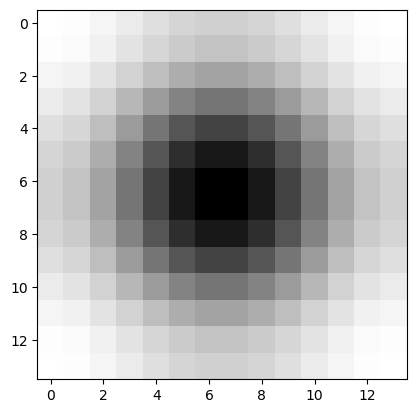

In [260]:
import matplotlib.pyplot as plt
%matplotlib inline
out=_gaussian_kernel.unsqueeze(0) * patch_drop
print(out.min(),out.max())
plt.imshow(  (out).permute(1, 2, 0).squeeze()  , cmap="gray")

In [261]:
import einops
patch_drop = einops.rearrange(_gaussian_kernel * patch_drop,  # use desired expected proba of dropping
                                          'nh nw -> (nh nw)')
patch_drop = einops.repeat(patch_drop, 'n -> b n e1 e2', e1=1, e2=1, b=b)

In [262]:
base_patch = torch.ones(1, 1, patch_size, patch_size).float()
rand = torch.rand((b, n_patches, 1, 1), device=base_patch.device)
masked_patches = (rand > patch_drop).float() * base_patch
mask = einops.rearrange(masked_patches, "b (nh nw) p1 p2 -> b (nh p1) (nw p2)",
                                nh=n_h_patch, nw=n_w_patch).unsqueeze(1)

tensor(0.2000) tensor(1.)


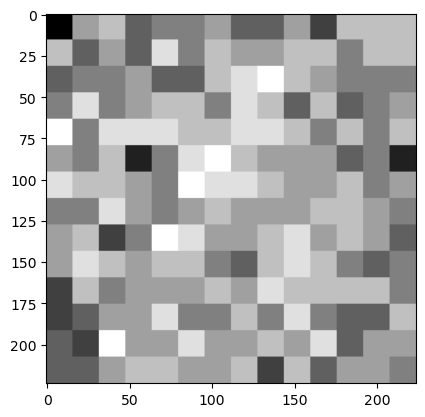

In [263]:
import matplotlib.pyplot as plt
%matplotlib inline
out=mask.mean(0)
print(out.min(),out.max())
plt.imshow(  (out).permute(1, 2, 0).squeeze()  , cmap="gray")

tensor(0.) tensor(1.)


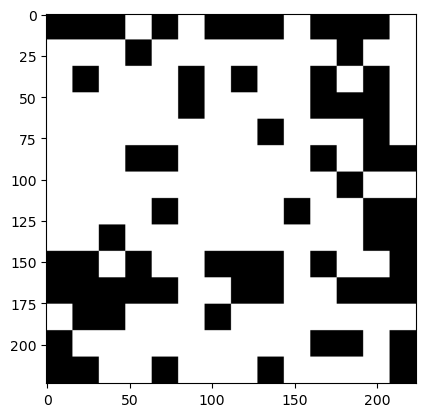

In [264]:
import matplotlib.pyplot as plt
%matplotlib inline
out=mask[1]
print(out.min(),out.max())
plt.imshow(  (out).permute(1, 2, 0).squeeze()  , cmap="gray")

In [217]:
out.shape

torch.Size([10, 196, 14, 14])

tensor(0.0447) tensor(0.2176)


RuntimeError: number of dims don't match in permute

In [220]:
patch_drop.shape

torch.Size([10, 196, 1, 1])

In [46]:
torchvision.transforms.functional.gaussian_blur??

Signature:
torchvision.transforms.functional.gaussian_blur(
    img: torch.Tensor,
    kernel_size: List[int],
    sigma: Optional[List[float]] = None,
) -> torch.Tensor
Source:   
def gaussian_blur(img: Tensor, kernel_size: List[int], sigma: Optional[List[float]] = None) -> Tensor:
    """Performs Gaussian blurring on the image by given kernel.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions.

    Args:
        img (PIL Image or Tensor): Image to be blurred
        kernel_size (sequence of ints or int): Gaussian kernel size. Can be a sequence of integers
            like ``(kx, ky)`` or a single integer for square kernels.

            .. note::
                In torchscript mode kernel_size as single int is not supported, use a sequence of
                length 1: ``[ksize, ]``.
        sigma (sequence of floats or float, optional): Gaussian kernel standard deviation. Can be a
            sequ

In [9]:
p = torch.rand(b)

In [15]:
from einops import rearrange, reduce, repeat

In [14]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.1 MB/s eta 0:00:00


In [16]:
repeat??

Signature: repeat(tensor: ~Tensor, pattern: str, **axes_lengths) -> ~Tensor
Source:   
def repeat(tensor: Tensor, pattern: str, **axes_lengths) -> Tensor:
    """
    einops.repeat allows reordering elements and repeating them in arbitrary combinations.
    This operation includes functionality of repeat, tile, broadcast functions.

    Examples for repeat operation:

    ```python
    # a grayscale image (of shape height x width)
    >>> image = np.random.randn(30, 40)

    # change it to RGB format by repeating in each channel
    >>> repeat(image, 'h w -> h w c', c=3).shape
    (30, 40, 3)

    # repeat image 2 times along height (vertical axis)
    >>> repeat(image, 'h w -> (repeat h) w', repeat=2).shape
    (60, 40)

    # repeat image 2 time along height and 3 times along width
    >>> repeat(image, 'h w -> (h2 h) (w3 w)', h2=2, w3=3).shape
    (60, 120)

    # convert each pixel to a small square 2x2. Upsample image by 2x
    >>> repeat(image, 'h w -> (h h2) (w w2)', h2=2, w2=2)